In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.layers import (
    MaxPool2D, Conv2D, Input,
    BatchNormalization, Dense, Activation,Flatten, Lambda, Add, Concatenate,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D
)

from tensorflow.keras import (
    Model, Sequential, utils, losses, metrics,
    optimizers, backend as K, callbacks,
    applications)

import h5py
import os
import seaborn as sns
import tensorflow as tf

from circles import (
    make_complex_circle,
    make_simple_circle,
    make_complex_dataset,
    make_simple_dataset,
    make_mesh,
    build_variate_dataset,
    read_dataset,
    run_multiprocess,
    structure_data,
    df_evaluation
)

from utils import (
    display_images,
    moving_average,
    plot_history,
    predict_and_errors,
    read_image
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('drive/MyDrive/Data')

In [ ]:
# Constant values
IMG_SIZE = 128
BATCH_SIZE = 128

In [ ]:
from tensorflow.python.ops.gen_math_ops import add
def cnn_count_model(shape):
    w, h, c = shape
    inputs = Input([w, h, c])
    conv_batch_1 = conv_layer(16, 7, 1)
    conv_batch_2 = conv_layer(32, 5, 1)
    conv_batch_3 = conv_layer(64, 5, 1)
    conv_batch_4 = conv_layer(128, 5, 1, on_max=False)
    flatten = Flatten()
    dense_1 = Dense(150, activation="relu")
    outputs = Dense(1, activation="linear")

    x = conv_batch_1(inputs)
    x = conv_batch_2(x)
    x = conv_batch_3(x)
    x = conv_batch_4(x)
    x = flatten(x)
    x = dense_1(x)
    outputs = outputs(x)

    return Model(inputs, outputs)

def conv_layer(n_filters, kernel=3, strides=1, padding='valid', on_max=True):
    seq = Sequential(
      [
       Conv2D(n_filters, kernel, strides, padding),
       BatchNormalization(),
       Activation('relu')
      ]
    )
    if on_max:
        seq.add(MaxPool2D(2, 2))

    return seq

## 1. Example of image generation, model training and evaluation

### Base model: build and training

In [ ]:
model = cnn_count_model((128, 128, 1))

In [ ]:
utils.plot_model(model, show_shapes=True)

In [ ]:
initial_learning_rate = 0.05
decay_steps = 1.0
decay_rate = 0.5
schedule = optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                 decay_steps,
                                                 decay_rate)
call_backs = [callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=3,
                                     patience=10,
                                     restore_best_weights=True),
             callbacks.LearningRateScheduler(schedule)
             ]

loss = losses.MeanAbsolutePercentageError()
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
metric = [
          #metrics.MeanAbsoluteError(),
          metrics.MeanSquaredError(),
          #metrics.MeanAbsolutePercentageError()]
]
model.compile(optimizer='rmsprop',
              loss=loss,
              metrics=metric
              )

model_history = model.fit(x=images, y=target,
                          batch_size=BATCH_SIZE,
                          epochs=50,
                          shuffle=True,
                          validation_split=0.1,
                          callbacks=call_backs
                          )

### Evaluation

#### Evaluation over random training data

In [ ]:
output = Lambda(lambda x: K.round(x)) (model.output)

In [ ]:
sample_indices = np.random.choice(np.arange(0, len(images)), 10, replace=False)
sample_images = images[sample_indices]
sample_target = target[sample_indices]

predict_and_errors(model, sample_images, sample_target)

Evaluation over unseen data with 1 to 10 circles.

In [ ]:
test_images, test_target = make_simple_dataset(n_examples=20, min_n_circles=1, max_n_circles=10)
test_images.shape, test_target.shape

In [ ]:
predict_and_errors(model, test_images[:5], test_target[:5])

Evaluation over unseen data with 10 to 50 circles.

In [ ]:
test_images_extra, test_extra_target = make_simple_dataset(n_examples=50, min_n_circles=10, max_n_circles=50)
test_images_extra.shape, test_extra_target.shape

In [ ]:
pred_extra, error_extra = predict_and_errors(model,
                                             test_images_extra,
                                             test_extra_target,
                                             on_return=True,
                                             on_show=False)

#### Plot frequency of predicted circle counts

In [ ]:
df = df_evaluation(error_extra, pred_extra)
sns.barplot(data=df.groupby('pred').mean().reset_index(),
            x='pred',
            y='error',
            )
_ = plt.xticks(rotation=30)

We see how mean prediction error increases when prediction is higher. This might
be because training limited to 1 to 10 range, thus, when unseen examples with more
than 10 circles are to be evaluated, the model performs worse.

Let's check the examples with unusual number of circles to get insights of the distribution of the circles.m

In [ ]:
display_images(test_images_extra,
               test_extra_target,
               n_examples=5)

Many circles overlap with each other, creating a cluster and losing the
circle like shape. This might lead the model to not properly detect individual
circles. This model downsize could be expected if training set only contains overall perfectly separated circles.

However, we can improve the data set maker function to avoid circles from overlapping. Another additional improvement would be using grayscale images, in other words, mostly black background and gray circles with variation of magnitude to allow the model to learn more complex features and end up generalizing in more real-world examples like images taken from cameras.

## 2. Enhanced features of circle dataset functions

#### Load the dataset from disk

In [ ]:
f_name = 'complex_images_1_20_128_128.hdf5'
with h5py.File(f_name) as f:
    images = f.get('images')[:]
    target = f.get('target')[:]
print(images.shape)
print(target.shape)

(1000, 128, 128, 1)
(1000,)


Distribution of number of circles in gray images

<BarContainer object of 20 artists>

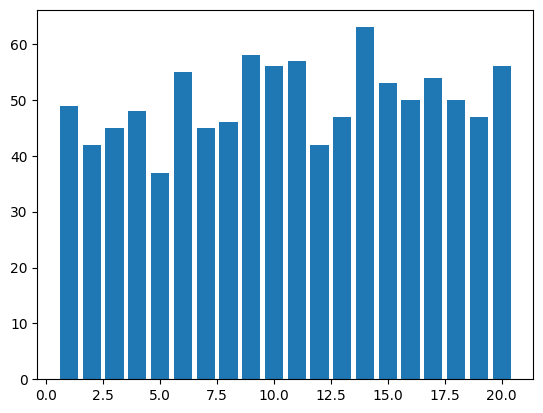

In [ ]:
u, c = np.unique(target, return_counts=True)
plt.bar(x=u, height=c)

These parameters don't outcome a proper model

+ epochs = 110
+ initial_learning_rate = 0.1
+ decay_steps = 1.0
+ decay_rate = 0.5
+ min_delta = 2
+ patience = 120

Metrics
+ metrics.MeanAbsoluteError(),
+ metrics.MeanSquaredError(),

Initial 0.1, final 0.05012531328320802 and reduced from maximum 0.5012531328320802


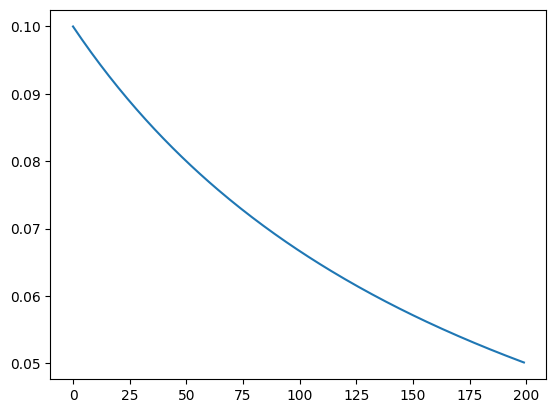

In [ ]:
x = np.arange(0, 200, 1)
lr_ini = 0.1
decay_rate = 1
decay_step = 200
f = lambda s: lr_ini / (1 + decay_rate * (s / decay_step))
y = f(x)
print(f"Initial {y.max()}, final {y.min()} and reduced from maximum {y.min() / y.max()}")
_ = plt.plot(x, y)

#### Mean squared error as loss function

In [ ]:
model_mse = cnn_count_model((IMG_SIZE, IMG_SIZE, 1))

epochs = 200
patience = 200
initial_learning_rate = 0.1
decay_steps = 50
decay_rate = 1.0

## Callbacks
# Time decay callback
schedule = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=True
)
early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    min_delta=1.0,
    patience=patience,
    restore_best_weights=True)

call_backs = [early_stopping,
              #callbacks.LearningRateScheduler(schedule)
              ]

# Loss
loss = losses.MeanSquaredError()
# Optimizer
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
# Metrics
metric = [
    metrics.MeanAbsoluteError(),
    #metrics.MeanSquaredError(),
    metrics.MeanAbsolutePercentageError()
]
# Compilation and model fitting
model_mse.compile(
    optimizer='rmsprop',
    loss=loss,
    metrics=metric
)

model_history_mse = model_mse.fit(x=images, y=target,
                              batch_size=BATCH_SIZE,
                              epochs=epochs,
                              shuffle=True,
                              validation_split=0.1,
                              callbacks=call_backs
                              )
model_history_mse

Epoch 1/200
8/8 [==============================] - 15s 204ms/step - loss: 771.1162 - mean_absolute_error: 14.2220 - mean_absolute_percentage_error: 237.1128 - val_loss: 120.2109 - val_mean_absolute_error: 9.4275 - val_mean_absolute_percentage_error: 96.5226
Epoch 2/200
8/8 [==============================] - 0s 57ms/step - loss: 10.0252 - mean_absolute_error: 2.4044 - mean_absolute_percentage_error: 31.4281 - val_loss: 119.5615 - val_mean_absolute_error: 9.3946 - val_mean_absolute_percentage_error: 95.9093
Epoch 3/200
8/8 [==============================] - 0s 53ms/step - loss: 12.0955 - mean_absolute_error: 2.6956 - mean_absolute_percentage_error: 30.1618 - val_loss: 100.9075 - val_mean_absolute_error: 8.3732 - val_mean_absolute_percentage_error: 77.7236
Epoch 4/200
8/8 [==============================] - 0s 49ms/step - loss: 23.3123 - mean_absolute_error: 3.4330 - mean_absolute_percentage_error: 45.8974 - val_loss: 112.1800 - val_mean_absolute_error: 8.9933 - val_mean_absolute_percentag

In [ ]:
model_history_mse.save("counter_4_conv2DBatch_1_hidden.keras")

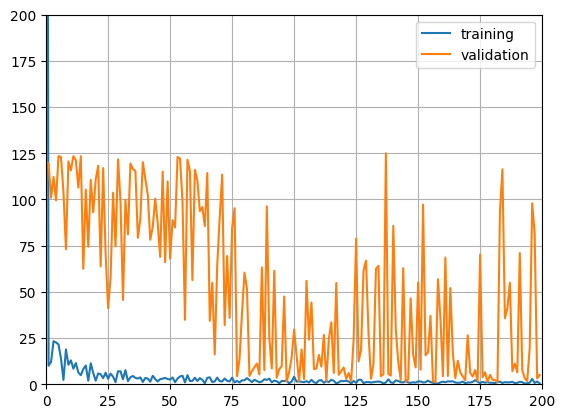

In [ ]:
plot_history(model_history_mse, lim=(0, 200, 0, 200))

Evaluation of training set sample

1/1 [==============================] - 0s 415ms/step


(None, None)

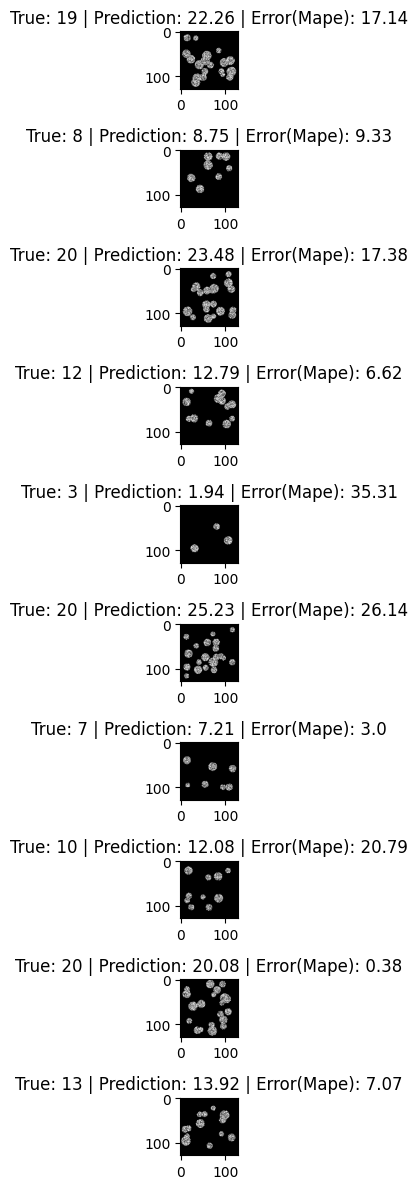

In [ ]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(images)),
                                  n_samples,
                                  replace=False)
sample_images = images[sample_indices]
sample_target = target[sample_indices].reshape(-1, 1)

predict_and_errors(model_mse, sample_images, sample_target)

In [ ]:
f_name = 'test_complex_images_1_20_128_128.hdf5'
with h5py.File(f_name) as f:
    test_images = f.get('images')[:]
    test_target = f.get('target')[:]
print(test_images.shape)
print(test_target.shape)

(50, 128, 128, 1)
(50,)


1/1 [==============================] - 0s 110ms/step


,error,pred
0,75.076355,0
6,80.007075,0
9,0.682932,4
7,24.226586,5
1,10.124426,6


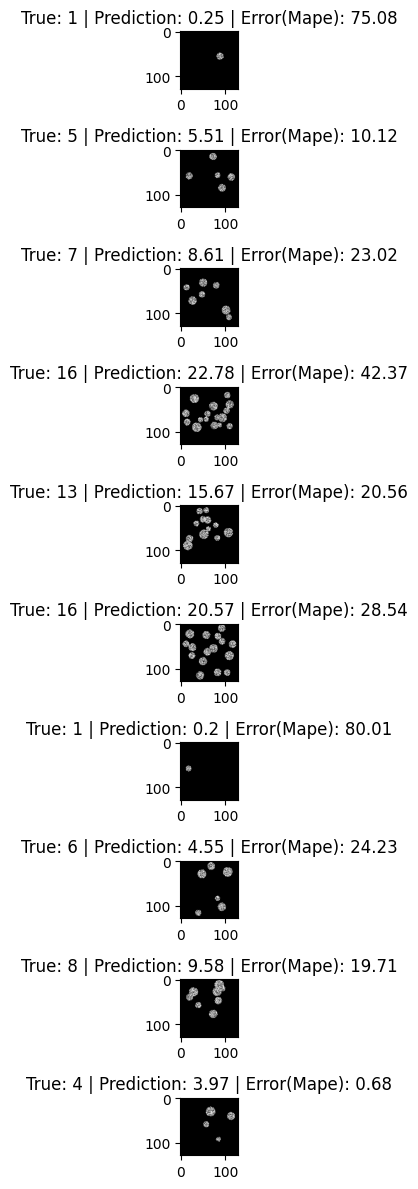

In [ ]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(test_images)),
                                  n_samples,
                                  replace=False)
sample_images = test_images[sample_indices]
sample_target = test_target[sample_indices].reshape(-1, 1)

pred_test, error_test = predict_and_errors(model_mse, sample_images, sample_target, on_return=True)

df = df_evaluation(error_test, pred_test)
df.head()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '0'),
  Text(1, 0, '4'),
  Text(2, 0, '5'),
  Text(3, 0, '6'),
  Text(4, 0, '9'),
  Text(5, 0, '10'),
  Text(6, 0, '16'),
  Text(7, 0, '21'),
  Text(8, 0, '23')])

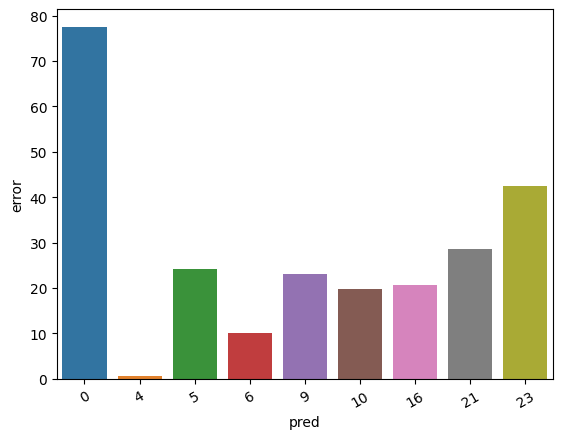

In [ ]:
sns.barplot(data=df.groupby('pred').mean().reset_index(), x='pred', y='error')
plt.xticks(rotation=30)

We conclude that model with MAPE loss gives better performance in terms of lower absolute error, even with values out of the training range up to 17 circles, for which we find the mean error (difference is 2).

We could try to improve this by

- Increasing number of filters in cnn layers.
- Better kernel, for example 3 to 5 or 5 to 7, size and downsampling
- Adding more cnn layers
- Adding skip layers (resnet) (concatenation or addition)

#### MAE as loss function

In [ ]:
model_mae = cnn_count_model((IMG_SIZE, IMG_SIZE, 1))

epochs = 200
patience = 200
initial_learning_rate = 0.1
decay_steps = 200
decay_rate = 1.0

## Callbacks
# Time decay callback
schedule = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=True
)
early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    min_delta=1.0,
    patience=patience,
    restore_best_weights=True)

call_backs = [early_stopping,
              callbacks.LearningRateScheduler(schedule)
              ]

# Loss
loss = losses.MeanAbsoluteError()
# Optimizer
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
# Metrics
metric = [
    metrics.MeanAbsoluteError(),
    #metrics.MeanSquaredError(),
    metrics.MeanAbsolutePercentageError()
]
# Compilation and model fitting
model_mae.compile(
    optimizer='rmsprop',
    loss=loss,
    metrics=metric
)

model_history_mae = model_mae.fit(x=images, y=target,
                                    batch_size=BATCH_SIZE,
                                    epochs=epochs,
                                    shuffle=True,
                                    validation_split=0.1,
                                    callbacks=call_backs
                                    )

model_history_mae

Epoch 1/200
8/8 [==============================] - 4s 89ms/step - loss: 5503.9707 - mean_absolute_error: 5503.9707 - mean_absolute_percentage_error: 110325.4844 - val_loss: 282.1540 - val_mean_absolute_error: 282.1540 - val_mean_absolute_percentage_error: 4282.8555 - lr: 0.1000
Epoch 2/200
8/8 [==============================] - 0s 49ms/step - loss: 6.1308 - mean_absolute_error: 6.1308 - mean_absolute_percentage_error: 71.2072 - val_loss: 21.9905 - val_mean_absolute_error: 21.9905 - val_mean_absolute_percentage_error: 336.2036 - lr: 0.1000
Epoch 3/200
8/8 [==============================] - 0s 48ms/step - loss: 8.5455 - mean_absolute_error: 8.5455 - mean_absolute_percentage_error: 86.9275 - val_loss: 168.6789 - val_mean_absolute_error: 168.6789 - val_mean_absolute_percentage_error: 2249.6218 - lr: 0.1000
Epoch 4/200
8/8 [==============================] - 0s 51ms/step - loss: 8.8057 - mean_absolute_error: 8.8057 - mean_absolute_percentage_error: 75.2136 - val_loss: 77.0527 - val_mean_abso

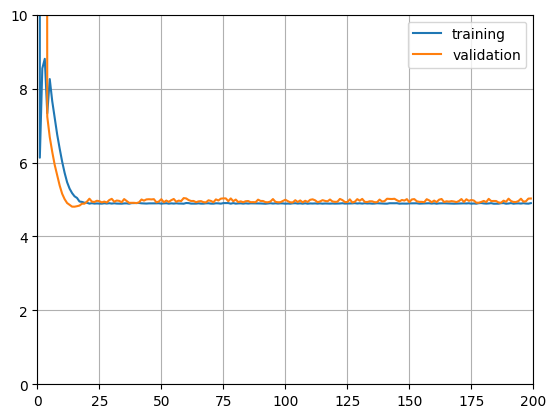

In [ ]:
plot_history(model_history_mae, lim=(0, 200, 0, 10))

1/1 [==============================] - 0s 121ms/step


(None, None)

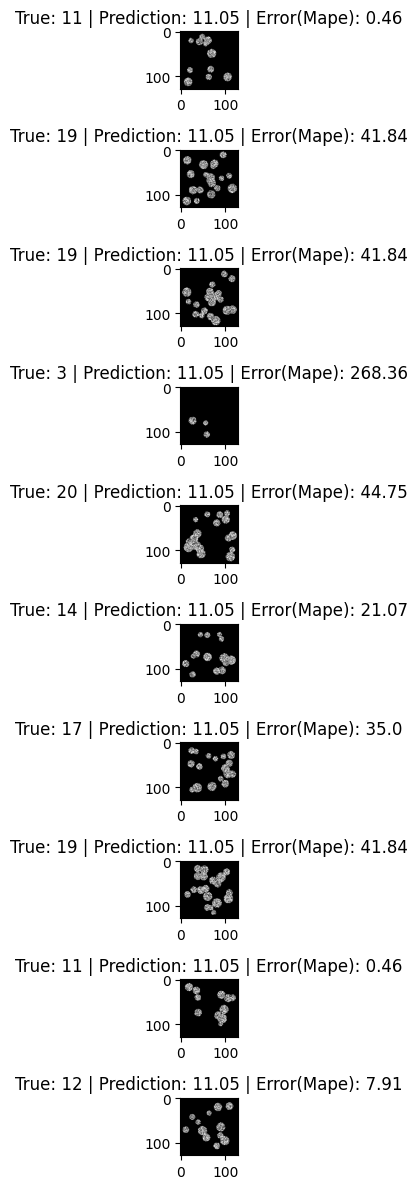

In [ ]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(images)),
                                  n_samples,
                                  replace=False)
sample_images = images[sample_indices]
sample_target = target[sample_indices].reshape(-1, 1)

predict_and_errors(model_mae, sample_images, sample_target)

1/1 [==============================] - 0s 19ms/step


,error,pred
0,22.785208,11
1,30.933321,11
2,1005.066872,11
3,44.746656,11
4,121.013374,11


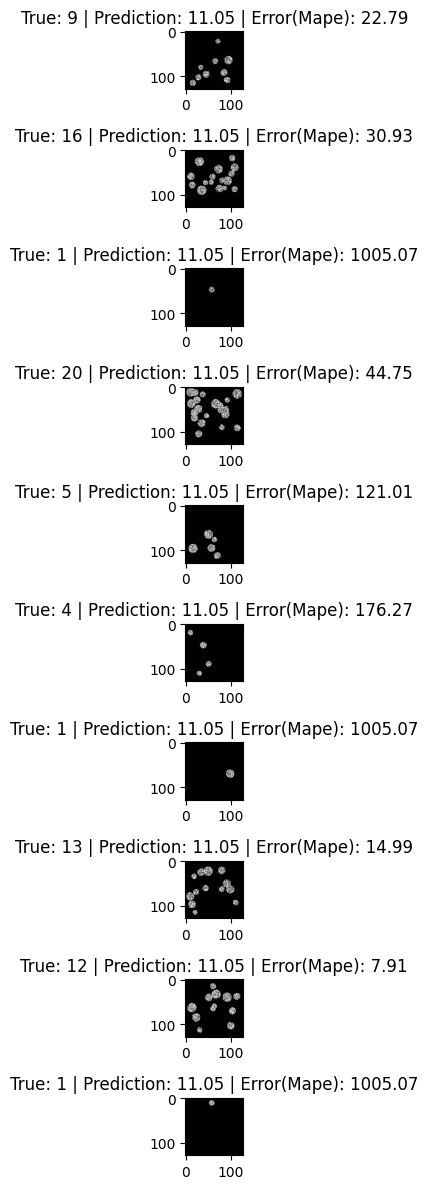

In [ ]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(test_images)),
                                  n_samples,
                                  replace=False)
sample_images = test_images[sample_indices]
sample_target = test_target[sample_indices].reshape(-1, 1)

pred_test, error_test = predict_and_errors(model_mae, sample_images, sample_target, on_return=True)

df = df_evaluation(error_test, pred_test)
df.head()

#### MAPE as loss function

In [ ]:
model_mape = cnn_count_model((IMG_SIZE, IMG_SIZE, 1))

epochs = 200
patience = 200
initial_learning_rate = 0.1
decay_steps = 50
decay_rate = 1.0

## Callbacks
# Time decay callback
schedule = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=True
)
early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    min_delta=1.0,
    patience=patience,
    restore_best_weights=True)

call_backs = [early_stopping,
              #callbacks.LearningRateScheduler(schedule)
              ]

# Loss
loss = losses.MeanAbsolutePercentageError()
# Optimizer
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
# Metrics
metric = [
    metrics.MeanAbsoluteError(),
    #metrics.MeanSquaredError(),
    metrics.MeanAbsolutePercentageError()
]
# Compilation and model fitting
model_mape.compile(
    optimizer='rmsprop',
    loss=loss,
    metrics=metric
)

model_history_mape = model_mape.fit(x=images, y=target,
                                    batch_size=BATCH_SIZE,
                                    epochs=epochs,
                                    shuffle=True,
                                    validation_split=0.1,
                                    callbacks=call_backs
                                    )

model_history_mape

Epoch 1/200
8/8 [==============================] - 3s 94ms/step - loss: 238.5636 - mean_absolute_error: 16.9173 - mean_absolute_percentage_error: 238.5636 - val_loss: 89.6247 - val_mean_absolute_error: 9.1029 - val_mean_absolute_percentage_error: 89.6247
Epoch 2/200
8/8 [==============================] - 0s 48ms/step - loss: 42.3886 - mean_absolute_error: 3.1655 - mean_absolute_percentage_error: 42.3886 - val_loss: 99.7364 - val_mean_absolute_error: 9.5871 - val_mean_absolute_percentage_error: 99.7364
Epoch 3/200
8/8 [==============================] - 0s 49ms/step - loss: 54.1822 - mean_absolute_error: 5.7409 - mean_absolute_percentage_error: 54.1822 - val_loss: 87.8511 - val_mean_absolute_error: 9.0085 - val_mean_absolute_percentage_error: 87.8511
Epoch 4/200
8/8 [==============================] - 0s 49ms/step - loss: 28.6944 - mean_absolute_error: 2.5793 - mean_absolute_percentage_error: 28.6944 - val_loss: 96.4576 - val_mean_absolute_error: 9.4245 - val_mean_absolute_percentage_erro

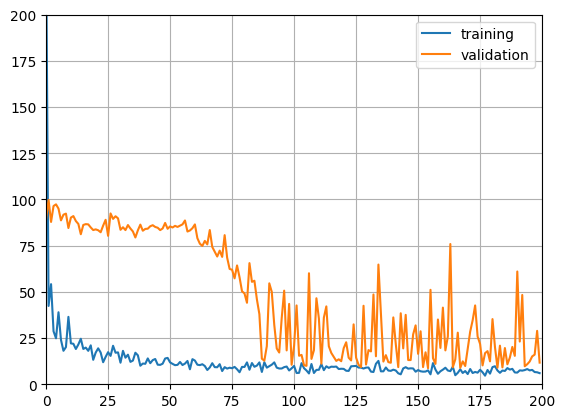

In [ ]:
plot_history(model_history_mape, lim=(0, 200, 0, 200))

1/1 [==============================] - 0s 22ms/step


(None, None)

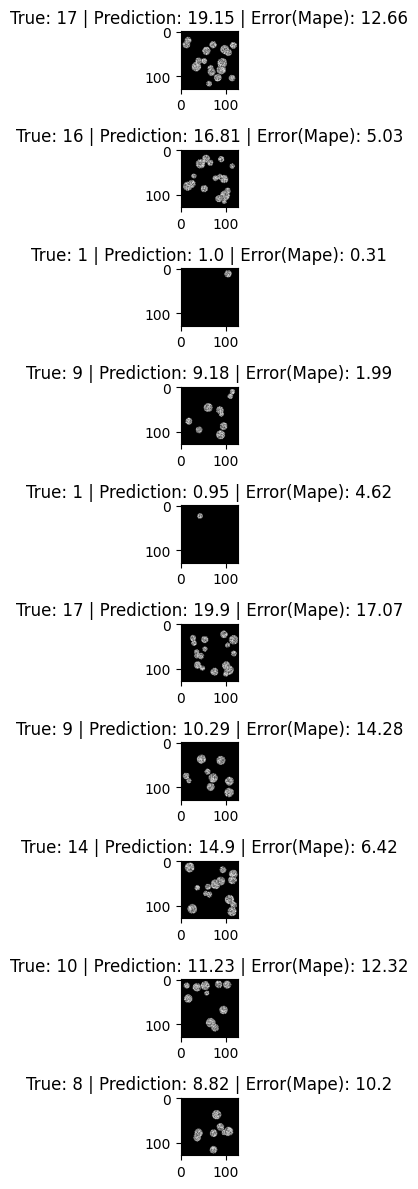

In [ ]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(images)),
                                  n_samples,
                                  replace=False)
sample_images = images[sample_indices]
sample_target = target[sample_indices].reshape(-1, 1)

predict_and_errors(model_mape, sample_images, sample_target)

1/1 [==============================] - 0s 21ms/step


NameError: ignored

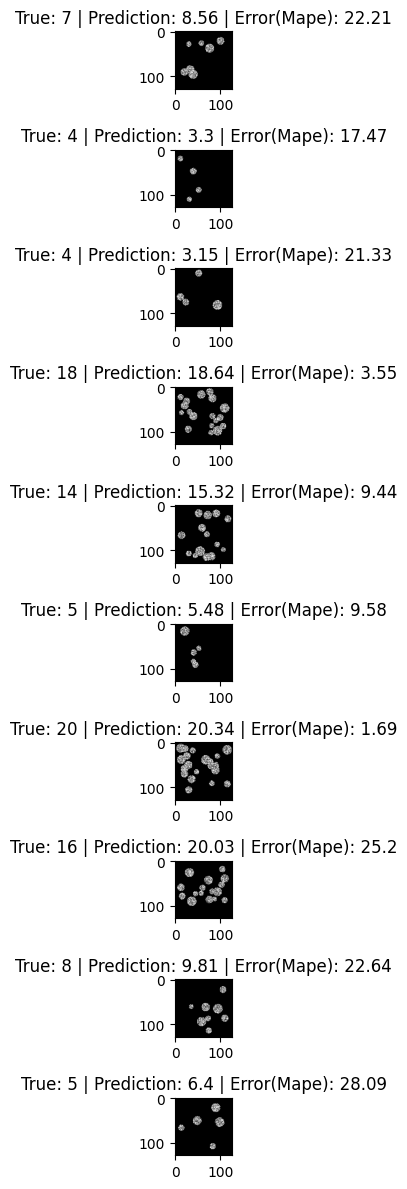

In [ ]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(test_images)),
                                  n_samples,
                                  replace=False)
sample_images = test_images[sample_indices]
sample_target = test_target[sample_indices].reshape(-1, 1)

pred_test, error_test = predict_and_errors(model_mape, sample_images, sample_target, on_return=True)

df = df_evaluation(error_test, pred_test)
df.head()

### Convolutional counting model with residual connection

In [ ]:
def res_cnn_counter(shape):
    w, h, c = shape
    inputs = Input([w, h, c])
    conv_batch_1_1 = conv_layer(16, 7, 1)
    conv_batch_1_2 = conv_layer(16, 7, 1, "same", False)
    conv_batch_2_1 = conv_layer(32, 5, 1)
    conv_batch_2_2 = conv_layer(32, 5, 1, "same", False)
    conv_batch_3_1 = conv_layer(64, 5, 1)
    conv_batch_3_2 = conv_layer(64, 5, 1, "same", False)
    conv_batch_4_1 = conv_layer(128, 5, 1)
    flatten = Flatten()
    dense_1 = Dense(150, activation="relu")
    outputs = Dense(1, activation="linear")

    # Sublayer
    x = conv_batch_1_1(inputs)
    x = conv_batch_1_2(x) + x

    x = conv_batch_2_1(x)
    x = conv_batch_2_2(x) + x

    x = conv_batch_3_1(x)
    x = conv_batch_3_2(x) + x

    x = conv_batch_4_1(x)

    x = flatten(x)
    x = dense_1(x)
    outputs = outputs(x)

    return Model(inputs, outputs)

In [ ]:
model_residual = res_cnn_counter((IMG_SIZE, IMG_SIZE, 1))

epochs = 200
patience = 200
initial_learning_rate = 0.1
decay_steps = 200
decay_rate = 1.0

## Callbacks
# Time decay callback
schedule = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=True
)
early_stopping = callbacks.EarlyStopping(
    monitor='loss', #'val_mean_absolute_percentage_error',
    min_delta=1.0,
    patience=patience,
    restore_best_weights=True)

call_backs = [early_stopping,
              callbacks.LearningRateScheduler(schedule)
              ]

# Loss
loss = losses.MeanSquaredError()
# Optimizer
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
# Metrics
metric = [
    metrics.MeanAbsoluteError(),
    #metrics.MeanSquaredError(),
    metrics.MeanAbsolutePercentageError()
]
# Compilation and model fitting
model_residual.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model_residual_history = model_residual.fit(x=images, y=target,
                                            batch_size=BATCH_SIZE,
                                            epochs=epochs,
                                            shuffle=True,
                                            validation_split=0.1,
                                            callbacks=call_backs
                                    )

Epoch 1/200
8/8 [==============================] - 6s 144ms/step - loss: 328207.3750 - mean_absolute_error: 246.6579 - mean_absolute_percentage_error: 3667.4478 - val_loss: 103040933888.0000 - val_mean_absolute_error: 301315.5938 - val_mean_absolute_percentage_error: 4196044.0000 - lr: 0.1000
Epoch 2/200
8/8 [==============================] - 1s 80ms/step - loss: 201.2649 - mean_absolute_error: 12.2619 - mean_absolute_percentage_error: 113.2184 - val_loss: 2287922.5000 - val_mean_absolute_error: 1014.7570 - val_mean_absolute_percentage_error: 14799.5010 - lr: 0.1000
Epoch 3/200
8/8 [==============================] - 1s 73ms/step - loss: 149.6794 - mean_absolute_error: 10.5772 - mean_absolute_percentage_error: 93.3483 - val_loss: 130.2846 - val_mean_absolute_error: 9.9471 - val_mean_absolute_percentage_error: 107.0002 - lr: 0.1000
Epoch 4/200
8/8 [==============================] - 1s 81ms/step - loss: 136.8311 - mean_absolute_error: 10.3391 - mean_absolute_percentage_error: 97.0598 - va

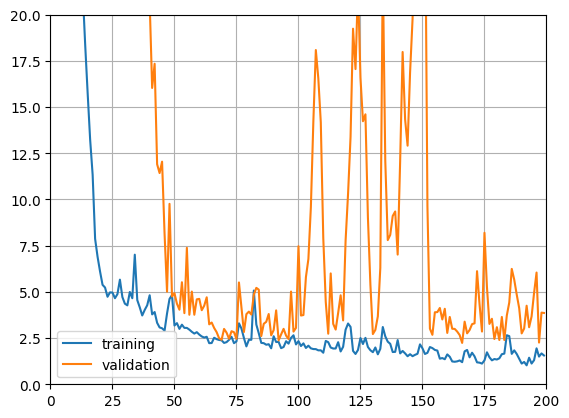

In [ ]:
plot_history(model_residual_history, lim=(0, 200, 0, 20))

In [ ]:
model_residual.save("counter_resnet.keras")

1/1 [==============================] - 0s 311ms/step


,error,pred
5,51.806657,5
2,31.290436,9
1,18.334875,12
0,25.482693,13
9,1.957866,14


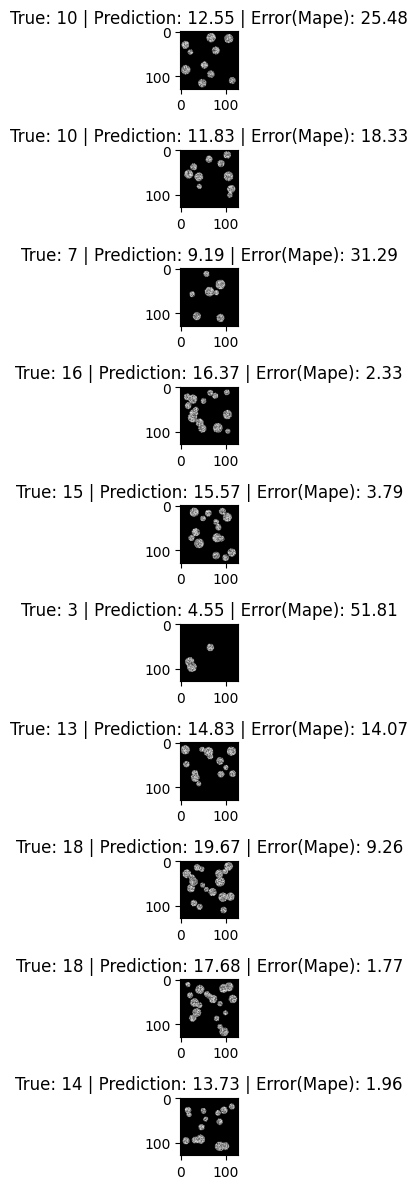

In [ ]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(images)),
                                  n_samples,
                                  replace=False)
sample_images = images[sample_indices]
sample_target = target[sample_indices].reshape(-1, 1)

pred_test, error_test = predict_and_errors(model_residual,
                                           sample_images,
                                           sample_target,
                                           on_return=True)

df = df_evaluation(error_test, pred_test)
df.head()

In [ ]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(test_images)),
                                  n_samples,
                                  replace=False)
sample_images = test_images[sample_indices]
sample_target = test_target[sample_indices].reshape(-1, 1)

pred_test, error_test = predict_and_errors(model_mae, sample_images, sample_target, on_return=True)

df = df_evaluation(error_test, pred_test)
df.head()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '5'),
  Text(1, 0, '9'),
  Text(2, 0, '12'),
  Text(3, 0, '13'),
  Text(4, 0, '14'),
  Text(5, 0, '15'),
  Text(6, 0, '16'),
  Text(7, 0, '18'),
  Text(8, 0, '20')])

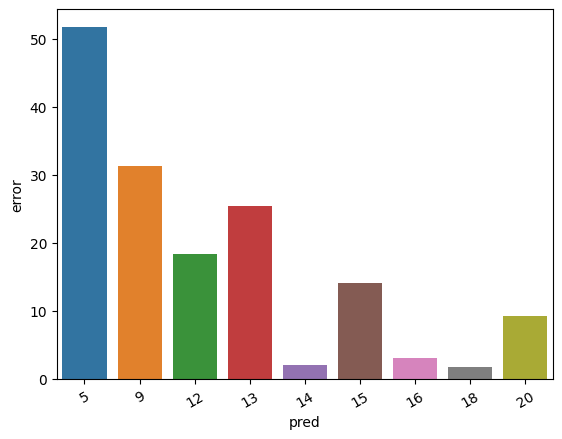

In [ ]:
sns.barplot(data=df.groupby('pred').mean().reset_index(), x='pred', y='error')
plt.xticks(rotation=30)

#### from fully dense layer to GAP (Global average pooling) layer on top

In [ ]:
from tensorflow.python.ops.gen_math_ops import add
def cnn_count_model(shape):
    w, h, c = shape
    inputs = Input([w, h, c])
    layer_1 = conv_layer(16, 7, 1, padding="same", on_max=False)
    layer_2 = conv_layer(16, 7, 1, on_max=True)
    layer_3 = conv_layer(32, 5, 1, on_max=False)
    layer_4 = conv_layer(32, 5, 2, on_max=True)
    layer_5 = conv_layer(64, 3, 1, on_max=False)
    layer_6 = conv_layer(64, 3, 1, on_max=False)
    layer_7 = GlobalAveragePooling2D()
    layer_8 = Dense(1, activation="linear")

    x = layer_1(inputs)
    x = layer_2(x)
    x = layer_3(x)
    x = layer_4(x)
    x = layer_5(x)
    x = layer_6(x)
    x = layer_7(x)
    outputs = layer_8(x)

    return Model(inputs, outputs)

def conv_layer(n_filters, kernel=3, strides=1, padding='valid', on_max=True):
    seq = Sequential(
        [
           Conv2D(n_filters, kernel, strides, padding),
           Activation('relu'),
           BatchNormalization(),
        ]
    )
    if on_max:
        seq.add(MaxPool2D(2, 2))

    return seq

In [52]:
model_gap_mse = res_cnn_counter((IMG_SIZE, IMG_SIZE, 1))

epochs = 200
patience = 200
initial_learning_rate = 0.1
decay_steps = 200
decay_rate = 1.0

## Callbacks
# Time decay callback
schedule = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=True
)
early_stopping = callbacks.EarlyStopping(
    monitor='loss', #'val_mean_absolute_percentage_error',
    min_delta=1.0,
    patience=patience,
    restore_best_weights=True)

call_backs = [early_stopping,
              callbacks.LearningRateScheduler(schedule)
              ]

# Loss
loss = losses.MeanSquaredError()
# Optimizer
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
# Metrics
metric = [
    metrics.MeanAbsoluteError(),
    #metrics.MeanSquaredError(),
    metrics.MeanAbsolutePercentageError()
]
# Compilation and model fitting
model_gap_mse_history.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model_gap_mse_history = model_gap_mse.fit(x=images, y=target,
                                            batch_size=BATCH_SIZE,
                                            epochs=epochs,
                                            shuffle=True,
                                            validation_split=0.1,
                                            callbacks=call_backs
                                    )
model_gap_mse_history

Epoch 1/200
8/8 [==============================] - 8s 344ms/step - loss: 184825.9062 - mean_absolute_error: 195.7083 - mean_absolute_percentage_error: 3982.2048 - val_loss: 87771416.0000 - val_mean_absolute_error: 9244.6064 - val_mean_absolute_percentage_error: 169918.2344 - lr: 0.1000
Epoch 2/200
8/8 [==============================] - 1s 70ms/step - loss: 46312.6055 - mean_absolute_error: 165.0190 - mean_absolute_percentage_error: 2742.4084 - val_loss: 6879.2202 - val_mean_absolute_error: 28.8330 - val_mean_absolute_percentage_error: 276.6016 - lr: 0.1000
Epoch 3/200
8/8 [==============================] - 1s 70ms/step - loss: 35384.5547 - mean_absolute_error: 115.0455 - mean_absolute_percentage_error: 1498.8853 - val_loss: 7006.3354 - val_mean_absolute_error: 76.5664 - val_mean_absolute_percentage_error: 1935.7080 - lr: 0.1000
Epoch 4/200
8/8 [==============================] - 1s 70ms/step - loss: 528.3593 - mean_absolute_error: 14.1885 - mean_absolute_percentage_error: 196.6552 - val

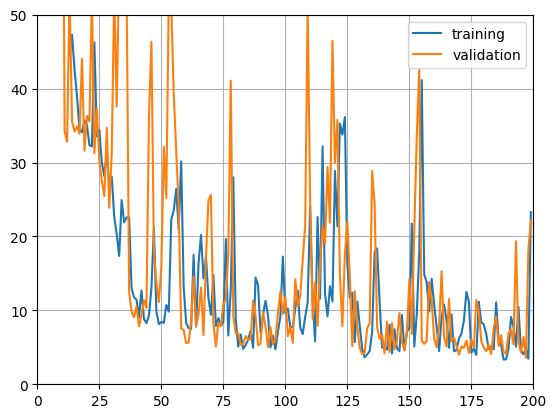

In [54]:
plot_history(model_gap_mse_history, lim=(0, 200, 0, 50))

1/1 [==============================] - 0s 431ms/step


,error,pred
3,85.203314,2
4,40.813255,2
5,11.219883,2
8,44.255942,2
6,61.256372,5


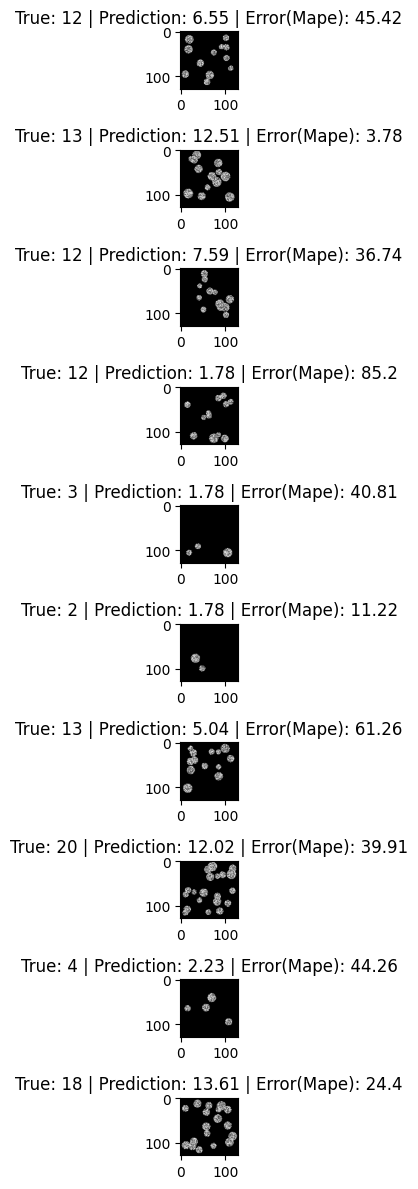

In [55]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(images)),
                                  n_samples,
                                  replace=False)
sample_images = images[sample_indices]
sample_target = target[sample_indices].reshape(-1, 1)

pred_test, error_test = predict_and_errors(model_gap_mse,
                                           sample_images,
                                           sample_target,
                                           on_return=True)

df = df_evaluation(error_test, pred_test)
df.head()

1/1 [==============================] - 0s 96ms/step


,error,pred
5,64.487953,2
6,77.560234,2
8,11.219883,2
0,29.996419,3
9,47.614717,4


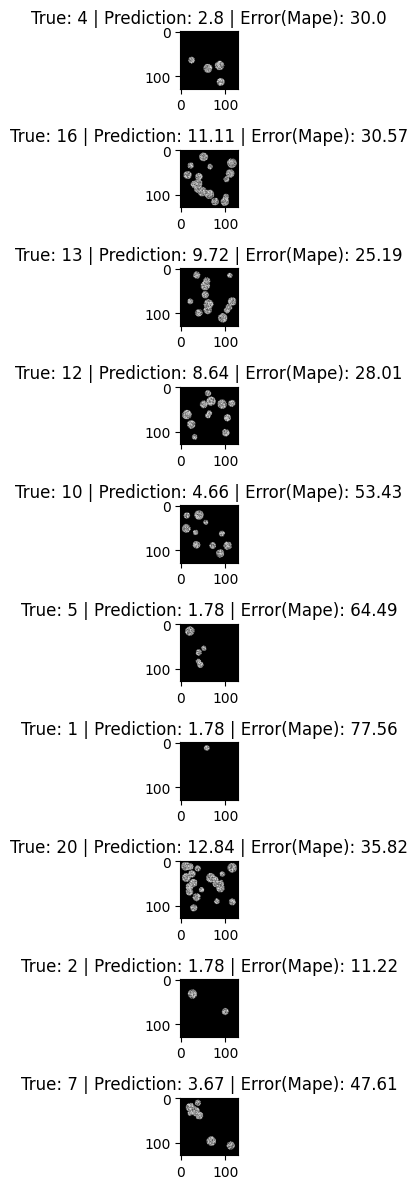

In [56]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(test_images)),
                                  n_samples,
                                  replace=False)
sample_images = test_images[sample_indices]
sample_target = test_target[sample_indices].reshape(-1, 1)

pred_test, error_test = predict_and_errors(model_gap_mse, sample_images, sample_target, on_return=True)

df = df_evaluation(error_test, pred_test)
df.head()